# SCC-ICMC-USP - 2o. semestre de 2021
# SCC0275 - Exercício 6

### Profa. Roseli A. F. Romero

### Monitor: Kenzo Sakiyama

Nro do grupo:

Alunos:


1.   Stefan Taiguara Couperus Leal - 10414866


## Parte 1 - Medidas de avaliação e bootstrap

---


### Carregando dados e definindo função de preprocessamento

Para as próximas questões, utilizaremos o dataset **breast_cancer** disponibilizado pelo sklearn. A descrição do conjunto de dados e de seus atributos será apresentada a seguir (atente-se ao atributo alvo "class").


In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import time as time

start = time.time()
cancer = load_breast_cancer()

df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df["class"] = cancer.target
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [2]:
# print(data["DESCR"])

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def preprocess(x_treino, x_teste, y_treino, y_teste):

    scaler = MinMaxScaler()
    # Computando estatísticas dos dados de treino
    scaler.fit(x_treino)
    # Transformando dados com a normalização MinMax
    x_treino_novo = scaler.transform(x_treino)
    x_teste_novo = scaler.transform(x_teste)

    # Não é necessário alterar os labels a menos que seja feito um tipo de amostragem (over/under sampling)
    y_treino_novo = y_treino
    y_teste_novo = y_teste

    return x_treino_novo, x_teste_novo, y_treino_novo, y_teste_novo


# confusion_matrix(y_test, y_pred)
def accuracy(y_test, y_pred):
    conf = confusion_matrix(y_test, y_pred)
    return (sum(np.diagonal(conf))) / (conf.sum())

df.shape

(569, 31)

### Questão 01. 

-  Implemente a técnica bootstrap utilizando a função abaixo
- Sugestão, utilize o material de apoio como referência

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from numpy import mean, std
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix

def classificacao_bootstrap(data, columns, target, preproc_fn, score_fn, score_name, conf_matrix_fn, 
                   no_bs=1000, p_teste=0.2, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    preproc_fn: Função. Faz o pré-processamento da base já separada em treino e teste 
    score_fn:   Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    conf_matrix_fn: Função. Calcula matriz de confusão 
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classiff    """
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron(n_jobs=-1)
    dt = DecisionTreeClassifier( criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    
    clfs = [prcp, dt]
    clfs_names = ['perceptron', 'dt']
    
    #Inicializa estruturas para matrizes de confusão 
    confusion_matrices = {
        'perceptron': np.zeros((2,2)),
        'dt': np.zeros((2,2)),
    }
    
    results = {'perceptron':[], 'dt':[]}
    
    no_exemplos = df.shape[0]
 
    scores = []
    for i in range(len(clfs_names)):
        for j in range(0, no_bs):
            amostra = data.sample(n = no_exemplos, replace=True) # Obtendo amostra do bootstrap

            X = amostra.iloc[:, 0:30] # Separando em dados 
            y = amostra.iloc[:, -1]  # e variável alvo

            X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=p_teste) # Split dos dados de maneira estratificada (mantendo prop. das classes)
            ss = StandardScaler()
            X_train = ss.fit_transform(X_train)
            X_test = ss.transform(X_test)

            data_train = pd.DataFrame(cancer.data, columns=cancer.feature_names)
            data_train["target"] = cancer.target

            classe_0 = data_train[data_train['target'] == 0]
            classe_1 = data_train[data_train['target'] == 1]
            n_elementos_classe_0 = data_train['target'].value_counts()[0] # Coletando o número de exemplos da classe 0 para superamostragem da classe 1  
            data_train = pd.concat([classe_0, classe_1.sample(n=n_elementos_classe_0, replace=True)]) # Superamostragem da classe 1 para numero de elementos da classe 0

            X_train, y_train = data_train.iloc[:, 0:30], data_train.iloc[:, -1] # reatribuição dos dados pra treino (agora superamostrados)

            clfs[i].fit(X_train, y_train) 
            y_pred = clfs[i].predict(X_test)
            results[clfs_names[i]].append(score_fn(y_test, y_pred))
   
    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.grid()
    plt.show()
    
    return {'results': results, 'clfs':clfs, 'confusion_matrices': confusion_matrices}

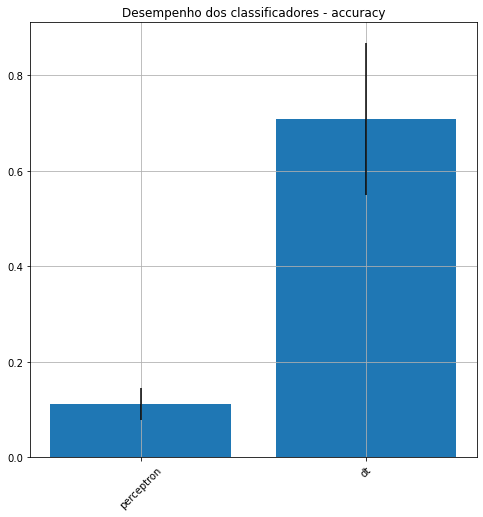

In [5]:
results = classificacao_bootstrap(df, cancer.data, cancer.target, preprocess, accuracy, "accuracy", confusion_matrix, 
                   no_bs=100, p_teste=0.2, plot=True)

### Questão 02. 

- Rode a função 4 vezes utilizando 2 métricas diferentes do **sklearn.metrics** (2 execuções por métrica);
- Compare os resultados e discuta as vantagens/desvantagens de cada uma das métricas

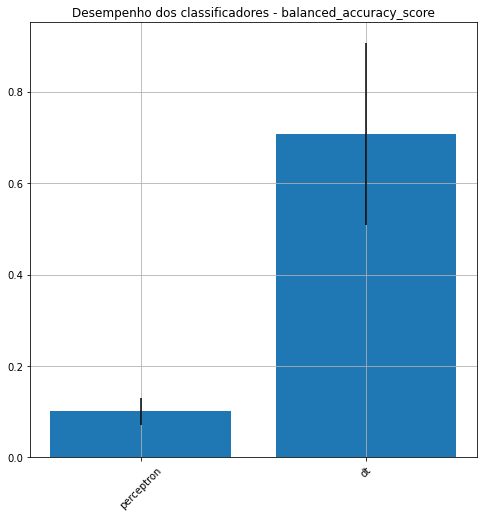

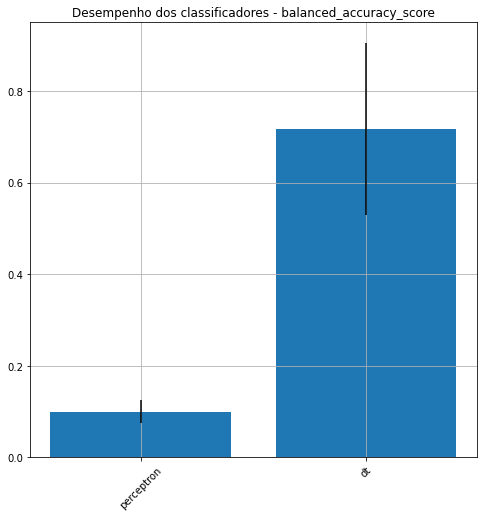

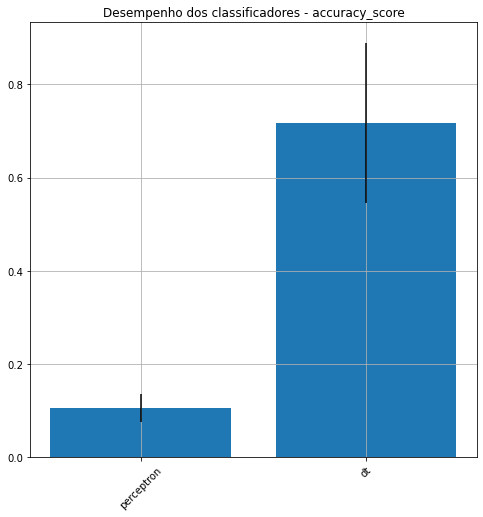

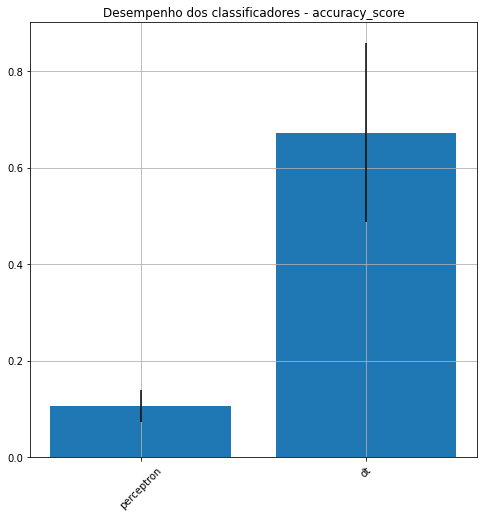

In [6]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

balanced_accuracy_score_0 = classificacao_bootstrap(df, cancer.data, cancer.target, preprocess,
                  balanced_accuracy_score, "balanced_accuracy_score",
                  confusion_matrix, 
                  no_bs=100, p_teste=0.2, plot=True)

balanced_accuracy_score_1 = classificacao_bootstrap(df, cancer.data, cancer.target, preprocess,
                  balanced_accuracy_score, "balanced_accuracy_score",
                  confusion_matrix, 
                  no_bs=100, p_teste=0.2, plot=True)

accuracy_score_0 = classificacao_bootstrap(df, cancer.data, cancer.target, preprocess,
                  accuracy_score, "accuracy_score",
                  confusion_matrix, 
                  no_bs=100, p_teste=0.2, plot=True)


accuracy_score_1 = classificacao_bootstrap(df, cancer.data, cancer.target, preprocess,
                  accuracy_score, "accuracy_score",
                  confusion_matrix, 
                  no_bs=100, p_teste=0.2, plot=True)



In [7]:
print("Balanced Score")
m1 = np.mean(balanced_accuracy_score_0["results"]["perceptron"])
m2 = np.mean(balanced_accuracy_score_1["results"]["perceptron"])
print("Perceptron: {:.2f} %".format(np.mean([m1, m2]) * 100))

m1 = np.mean(balanced_accuracy_score_0["results"]["dt"])
m2 = np.mean(balanced_accuracy_score_1["results"]["dt"])
print("dt: {:.2f} %".format(np.mean([m1, m2]) * 100))

print("\nAccuracy Score")
m1 = np.mean(accuracy_score_0["results"]["perceptron"])
m2 = np.mean(accuracy_score_1["results"]["perceptron"])
print("Perceptron: {:.2f} %".format(np.mean([m1, m2]) * 100))

m1 = np.mean(accuracy_score_0["results"]["dt"])
m2 = np.mean(accuracy_score_1["results"]["dt"])
print("dt: {:.2f} %".format(np.mean([m1, m2]) * 100))


# print("Usando o accuracy score nós obtemos uma precisão ") #TODO: TERMINAR QUESTÃO

Balanced Score
Perceptron: 10.04 %
dt: 71.17 %

Accuracy Score
Perceptron: 10.70 %
dt: 69.47 %


## Parte 2 - Curva ROC e Teste de hipótese

## Funções novas utilizadas no exercício

- `pandas.Series.nunique()` ([link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.nunique.html)): Conta quantidade de valores únicos de uma coluna. Útil para verificar se uma coluna é relevante ou não
- `scipy.stats.ttest_ind()` ([link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind)): Calcula o teste t para duas amostras independentes
- `sklearn.metrics.plot_roc_curve()` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html)): Plota a curva ROC de um classificador dado um conjunto de input e alvo

### Questão 01.

Faça a exploração dos dados. Isto é, carregue, substitua valores faltantes, padronize os dados, etc. Faça também a seleção dos atributos que achar mais relevantes. 

 - Dica: Utilize a função `nunique()` durante a exploração dos dados. Você pode utilizar o "bom senso" (além de outras ferramentas é claro) na hora de escolher qual atributo do conjunto manter

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("titanic.csv")
# df.info()
df = df.drop(columns=["Name", "Ticket", "Cabin"])
df.isna().sum()

df['Sex'] = df["Sex"].map({"male": 0, "female": 1})
df['Embarked'] = df["Embarked"].map({"C": 0, "Q": 1, "S": 2})

In [9]:
# Etapas de pré-processamento que podem ser feitas antes de separar em treino/teste vão aqui
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def transformar_base(df):
    
    features_categoricos = df.dtypes==object
    features_categoricos = df.columns[features_categoricos].tolist()

    features_numericos = df.dtypes!=object
    features_numericos = df.columns[features_numericos].tolist()
    # Criando os pipelines

    pipeline_numerico = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
    ]) #('scaler', StandardScaler())
    
    pipeline_categorico = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent'))
        ]) #('onehot', OneHotEncoder(handle_unknown='ignore'))

    # Criando a transformação do conjunto de dados:
    transformacao = ColumnTransformer(
        transformers=[
            ('transformacao numerica', pipeline_numerico, features_numericos),
            ('transformacao categorica', pipeline_categorico, features_categoricos),        
        ])
    # Aplicando a transformação no dataset:
    dados_transformados = pd.DataFrame(transformacao.fit_transform(df))
    dados_transformados.columns = df.columns

    return dados_transformados

dados_transformados = pd.DataFrame(transformar_base(df))
dados_transformados = dados_transformados.iloc[: , 1:]
dados_transformados

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3.0,0.0,22.000000,1.0,0.0,7.2500,2.0
1,1.0,1.0,1.0,38.000000,1.0,0.0,71.2833,0.0
2,1.0,3.0,1.0,26.000000,0.0,0.0,7.9250,2.0
3,1.0,1.0,1.0,35.000000,1.0,0.0,53.1000,2.0
4,0.0,3.0,0.0,35.000000,0.0,0.0,8.0500,2.0
...,...,...,...,...,...,...,...,...
886,0.0,2.0,0.0,27.000000,0.0,0.0,13.0000,2.0
887,1.0,1.0,1.0,19.000000,0.0,0.0,30.0000,2.0
888,0.0,3.0,1.0,29.699118,1.0,2.0,23.4500,2.0
889,1.0,1.0,0.0,26.000000,0.0,0.0,30.0000,0.0


In [10]:
dados_transformados.isna().any()

Survived    False
Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked    False
dtype: bool

In [11]:
# Etapas de pré-processamento que serão feitas após os dados estarem divididos vão na função
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Balanceando no conjunto de treino 

classe_0 = dados_transformados[dados_transformados["Survived"] == 0]
classe_1 = dados_transformados[dados_transformados["Survived"] == 1]
df_new = pd.concat([classe_0, classe_1.sample(n=207, replace=True)])

x_treino, x_teste, y_treino, y_teste = train_test_split(df_new.loc[:, df_new.columns != "Survived"], 
                                                                    df_new["Survived"],
                                                        test_size = 0.3,random_state = 0)

x_treino.shape

(529, 7)

### Questão 02.

Separe o conjunto de dados de maneira estratificada (através do parâmetro `stratify` da função `train_test_split`) em 20% para teste e 80% para treino. Depois plote a curva ROC (`sklearn.metrics.plot_roc_curve`) para **todos** os classificadores (no mesmo gráfico). 

Os melhores classificadores da questão anterior também apresentaram melhor desempenho na curva ROC? O que pode ter ocorrido? Teste diferentes valores de `random_state` na função `train_test_split` e observe o comportamento das curvas.


*   Dica: Para plotar múltiplas curvas ROC no mesmo gráfico, defina uma figura com `fig, ax = plt.subplots()` e passe `ax` como parâmetro da função `plot_roc_curve`. Não se esqueça de passar também o nome do classificador para que o seu gráfico fique mais fácil de interpretar



In [12]:
# Separar conjunto e pré processamento
df_novo = dados_transformados.copy(deep=True)

y = df_novo["Survived"]
X = df_novo


In [13]:
df_novo.shape

(891, 8)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = 0)

X_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
140,0.0,3.0,1.0,29.699118,0.0,2.0,15.2458,0.0
439,0.0,2.0,0.0,31.000000,0.0,0.0,10.5000,2.0
817,0.0,2.0,0.0,31.000000,1.0,1.0,37.0042,0.0
378,0.0,3.0,0.0,20.000000,0.0,0.0,4.0125,0.0
491,0.0,3.0,0.0,21.000000,0.0,0.0,7.2500,2.0
...,...,...,...,...,...,...,...,...
835,1.0,1.0,1.0,39.000000,1.0,1.0,83.1583,0.0
192,1.0,3.0,1.0,19.000000,1.0,0.0,7.8542,2.0
629,0.0,3.0,0.0,29.699118,0.0,0.0,7.7333,1.0
559,1.0,3.0,1.0,36.000000,1.0,0.0,17.4000,2.0


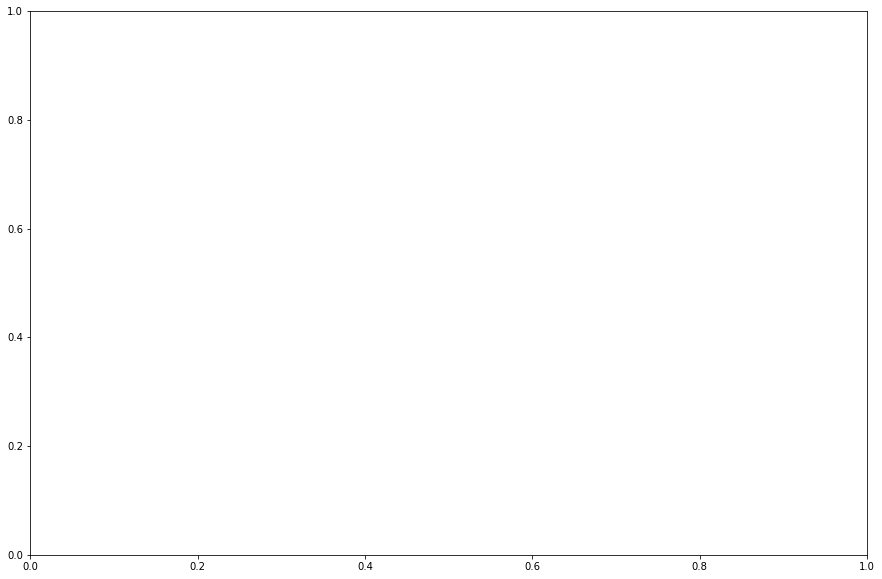

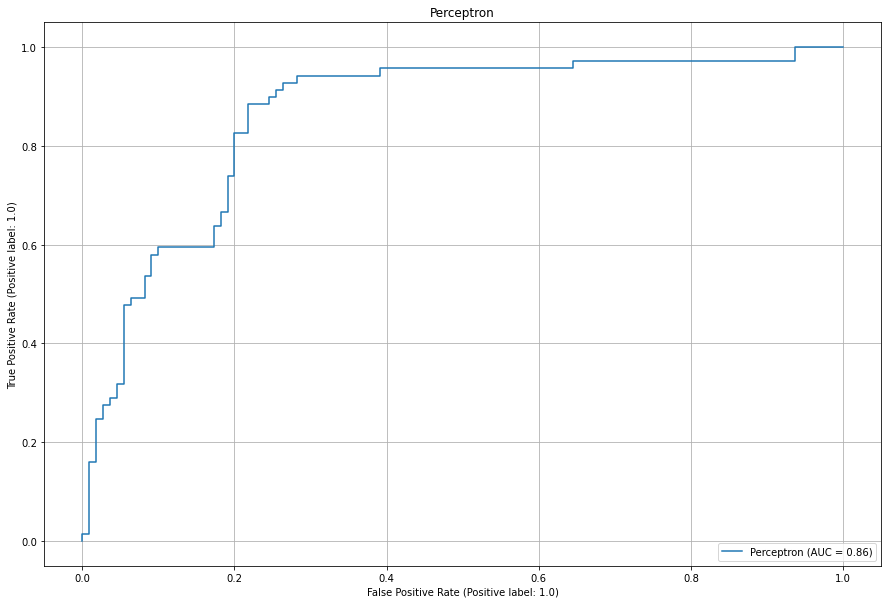

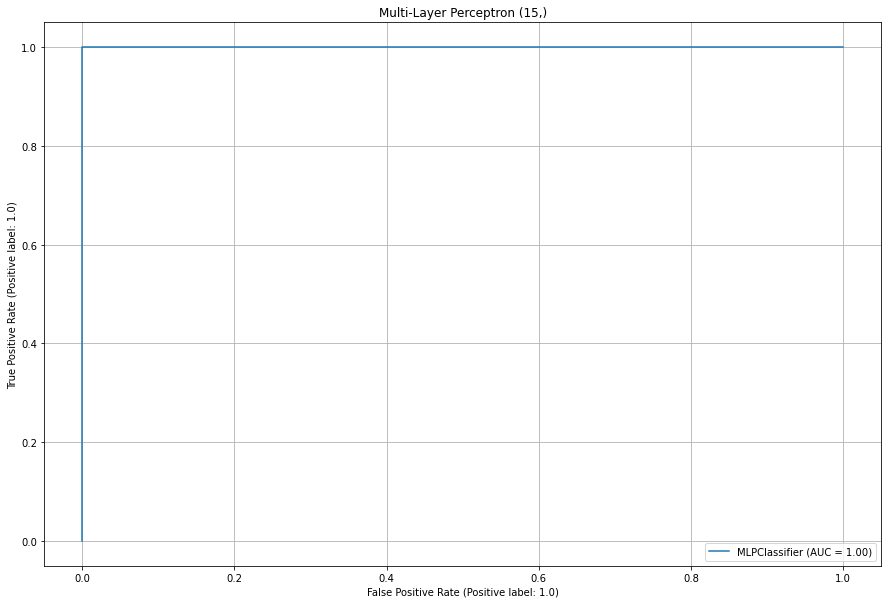

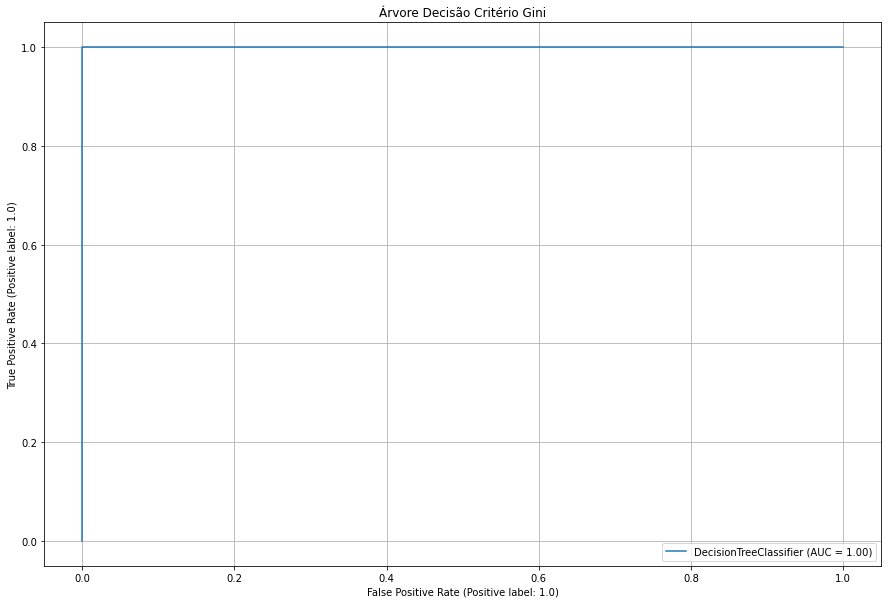

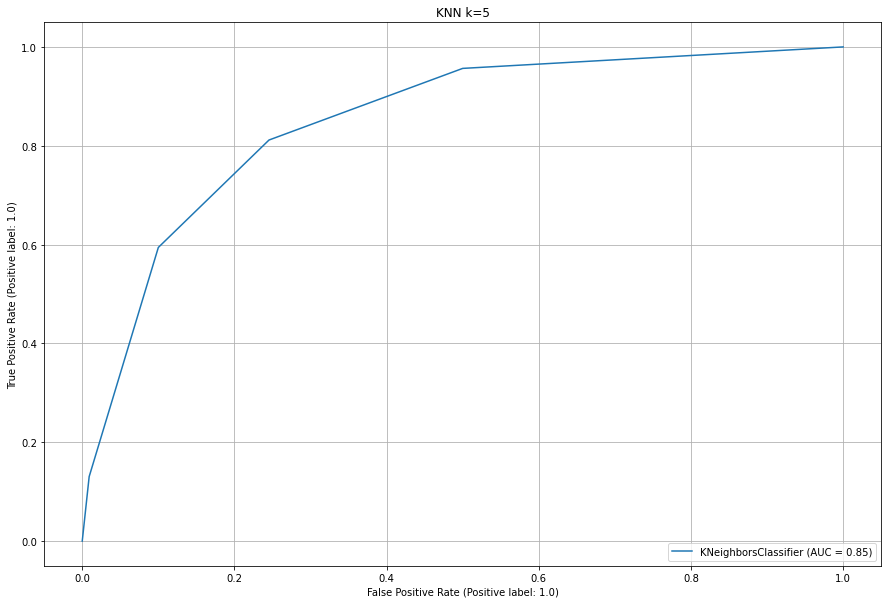

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, metrics
import numpy as np


classificadores = {
  "Perceptron" : {"modelo": Perceptron(n_jobs=-1), "scores": []},
  "Multi-Layer Perceptron (15,)" : {"modelo": MLPClassifier(  hidden_layer_sizes=(15,), max_iter=2000), "scores": []},
  "Árvore Decisão Critério Gini" : {"modelo": DecisionTreeClassifier( criterion='gini'), "scores": []},  
  "KNN k=5" : {"modelo": KNeighborsClassifier(n_neighbors=5, n_jobs=-1 ), "scores": []}
}

plt.rcParams['figure.figsize'] = [15, 10]
fig, ax = plt.subplots()
for classificador_name in classificadores:  
    
    classificadores[classificador_name]["modelo"].fit(X=X_train, y=y_train) # 2) Fit

    # valores preditos pelo classificador
    y_pred = classificadores[classificador_name]["modelo"].predict(X_test)  # 3) Predict
    y_test = np.array(y_test)

    classificadores[classificador_name]["scores"].append(balanced_accuracy_score(y_test, y_pred))
    metrics.plot_roc_curve(classificadores[classificador_name]["modelo"], X_test, y_test) 

 # 4) Avaliação com plot_roc_curve
    plt.title(classificador_name)
    plt.grid()
    plt.show() 

### Questão 03.

Implemente o 10-Fold Cross Validation (pode usar o scikit) com os dois melhores classificadores de acordo com a curva ROC e guarde a acurácia de cada fold na chave 'scores' do dicionário de classificadores.
- Sugestão: utilize o gabarito do Ex7 como referência para implementação.

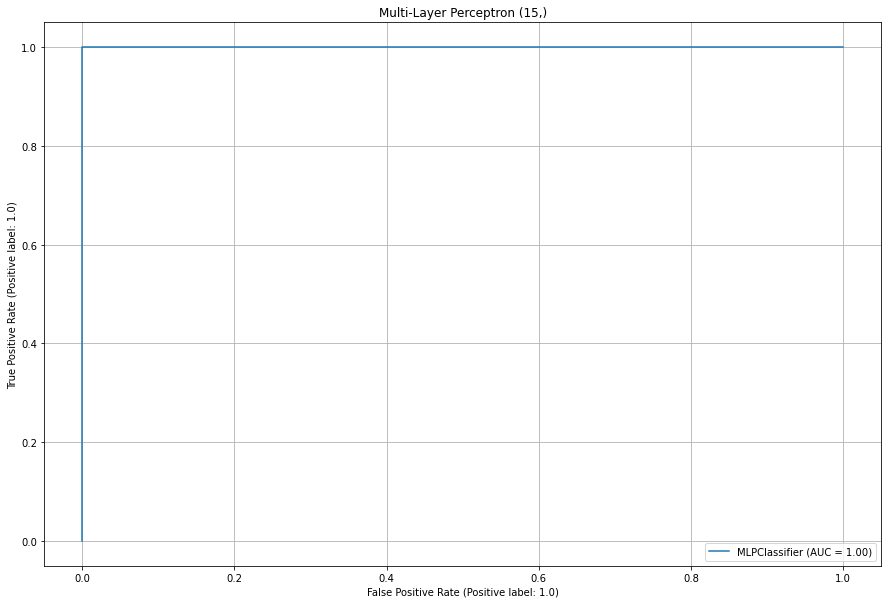

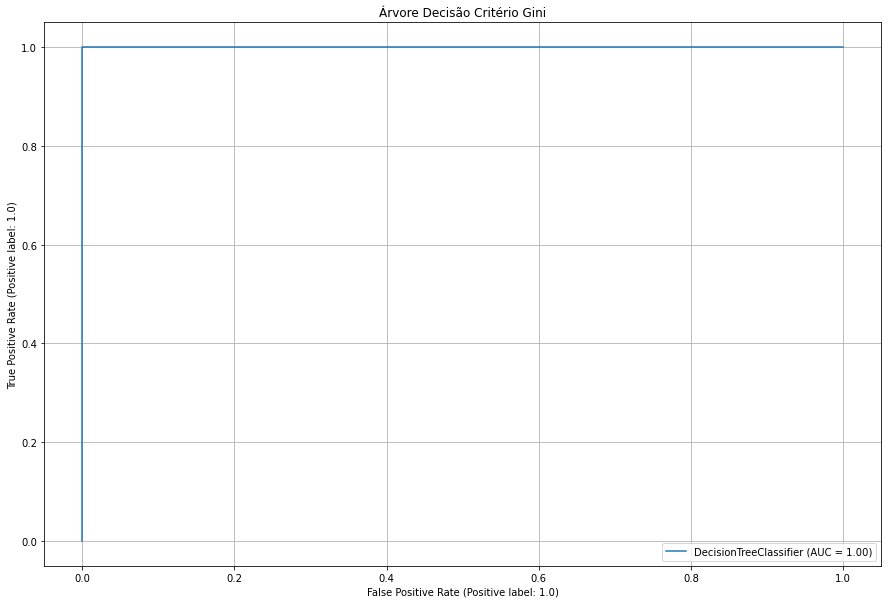

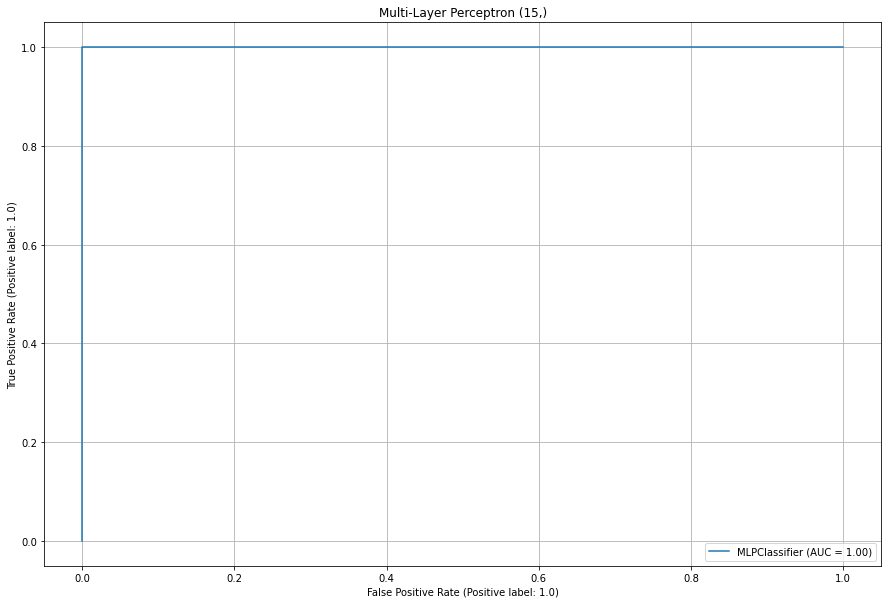

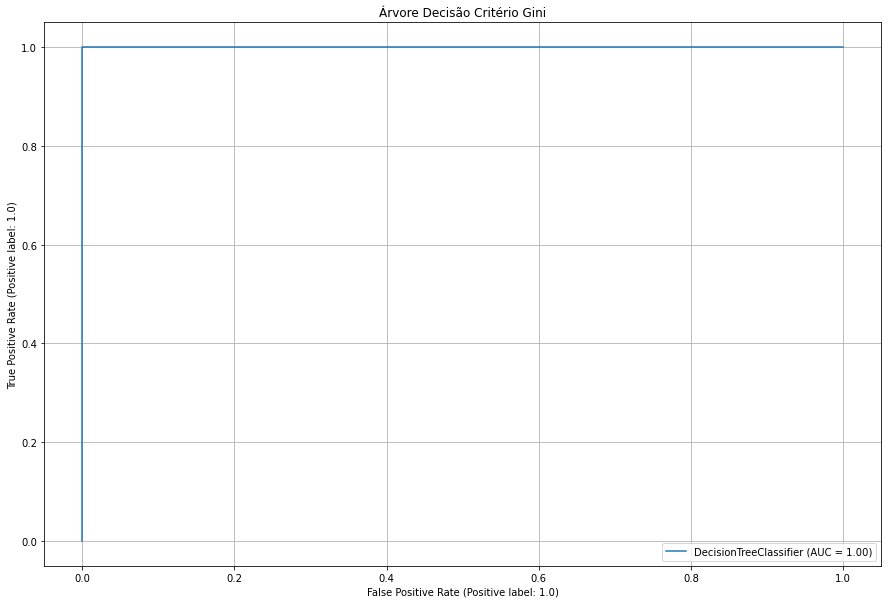

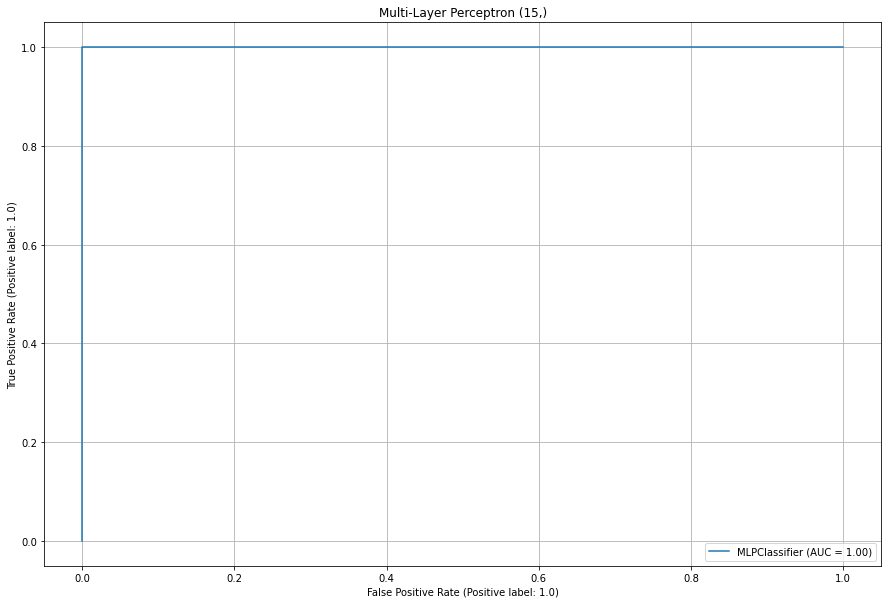

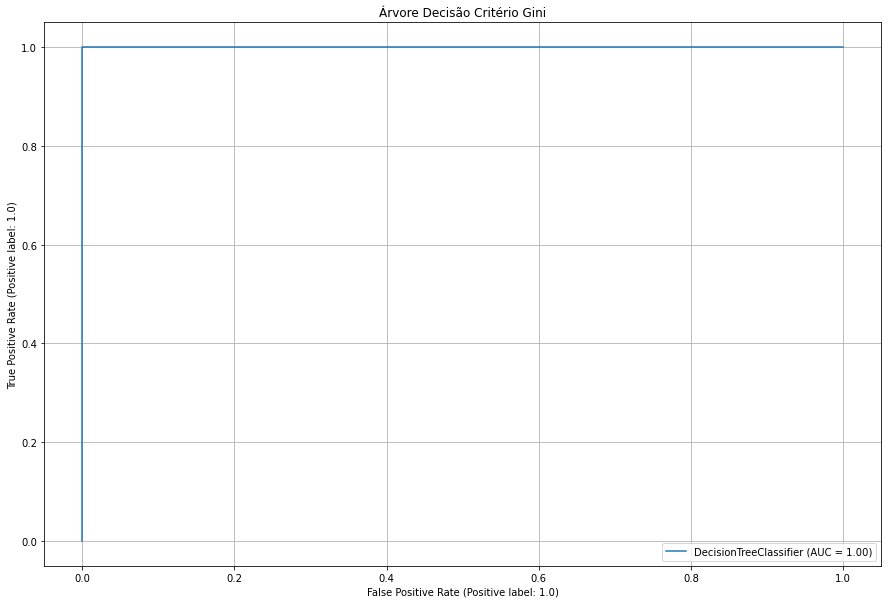

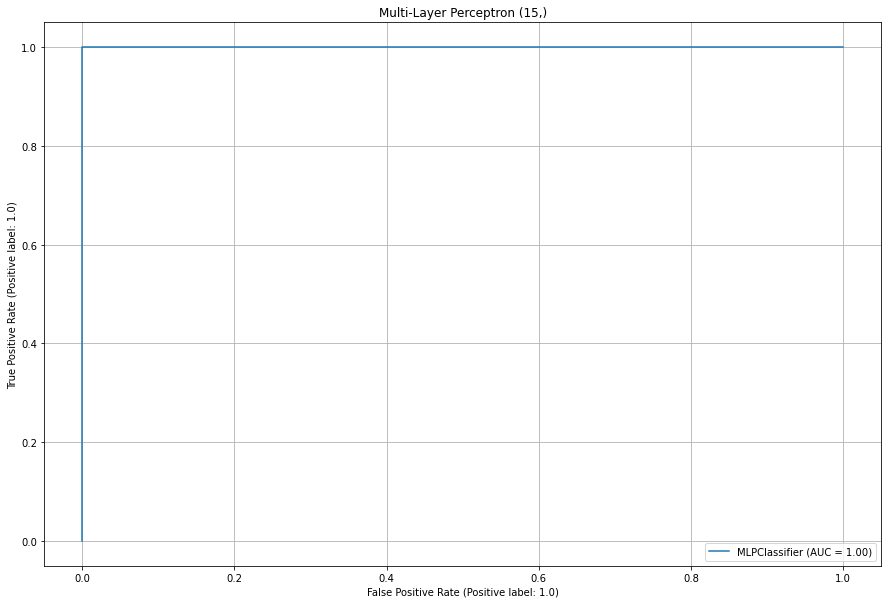

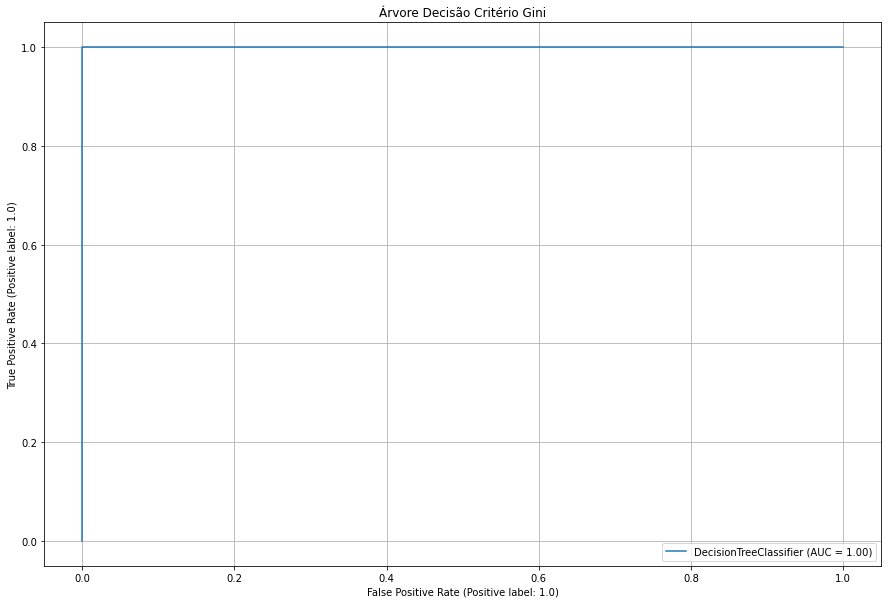

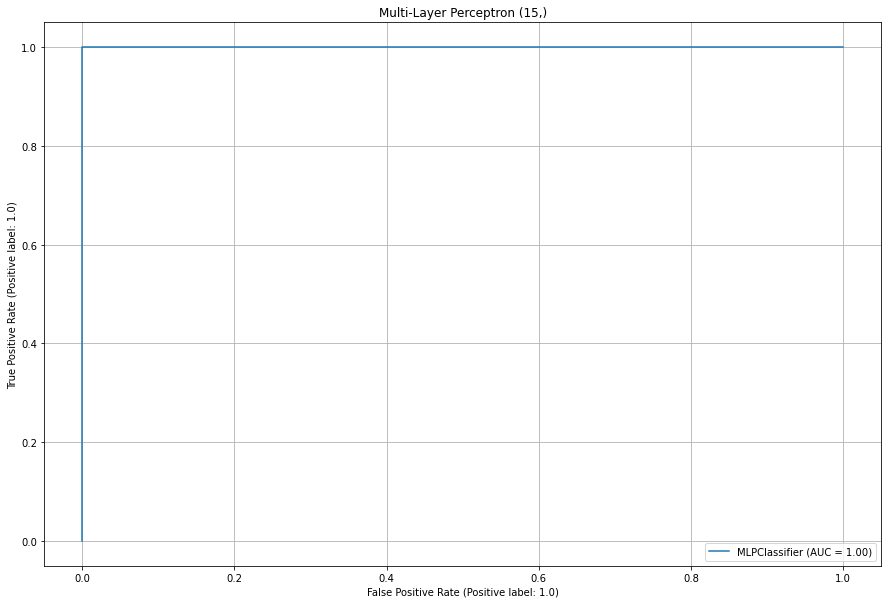

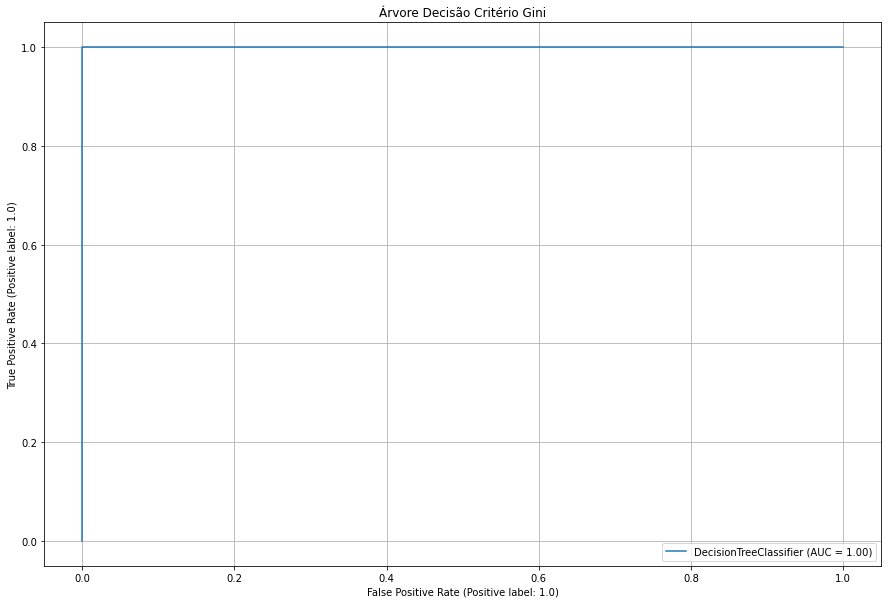

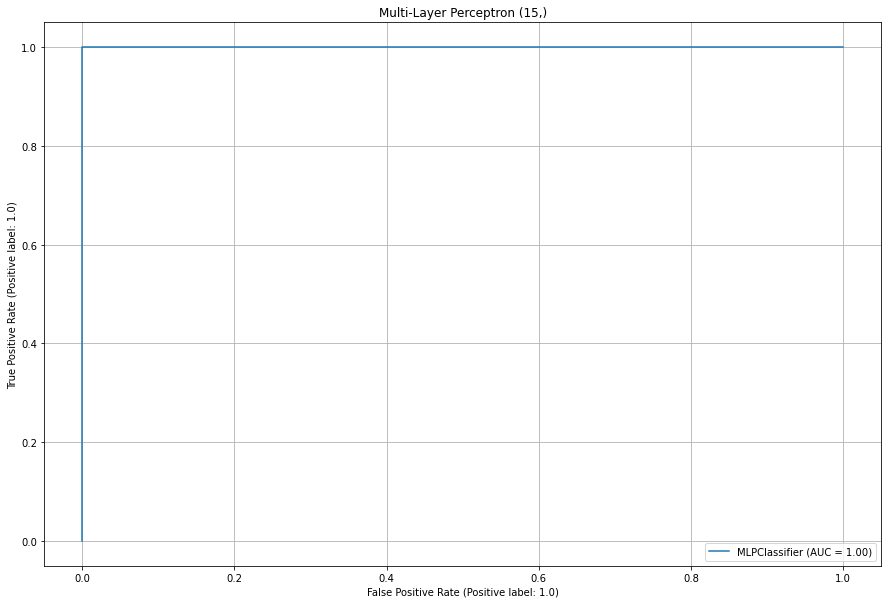

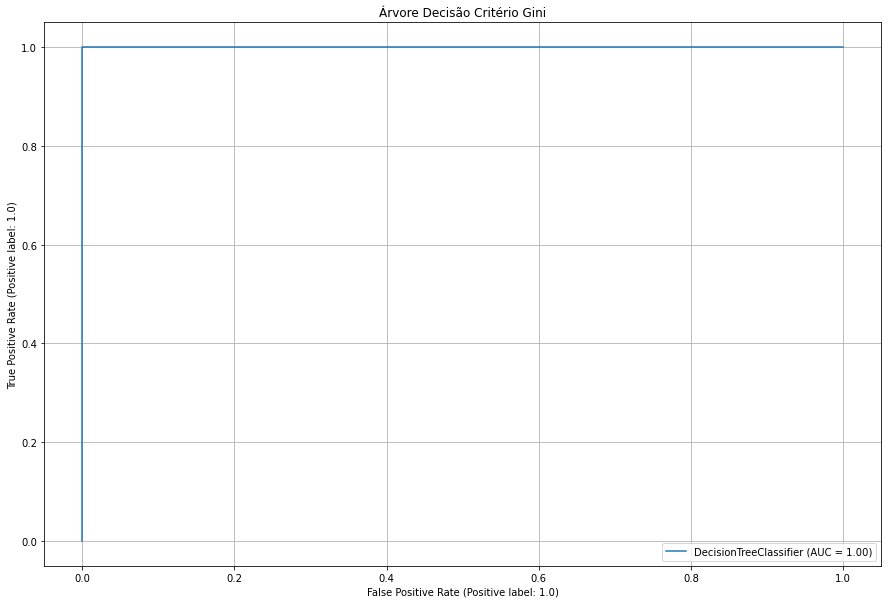

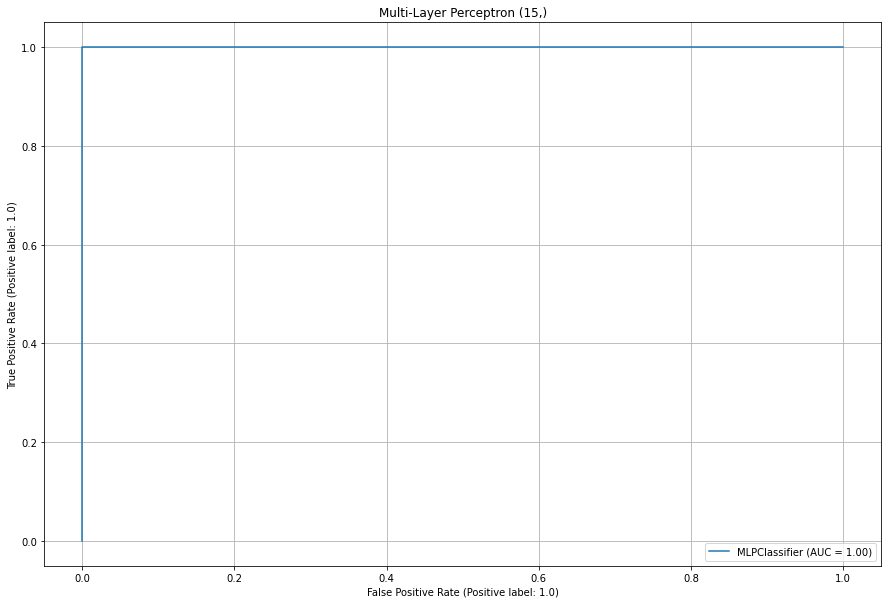

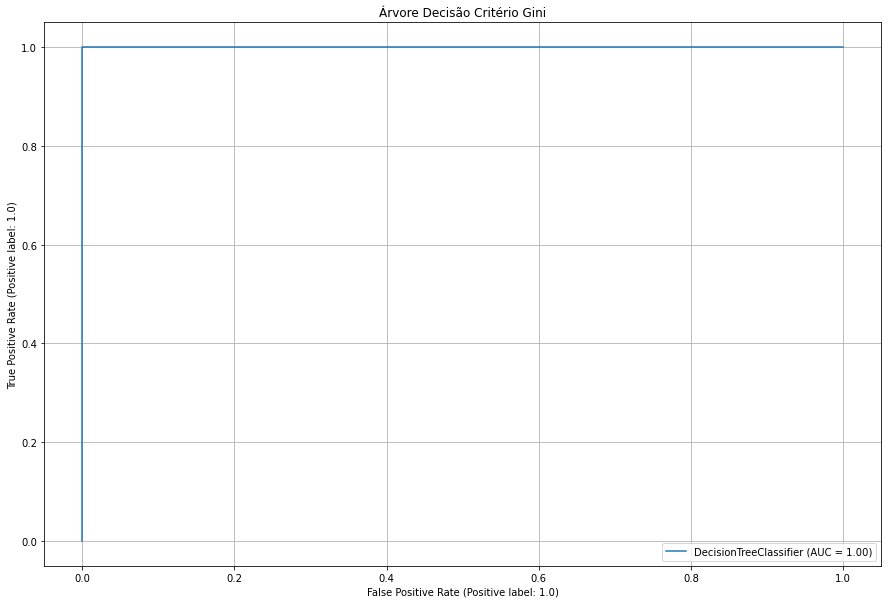

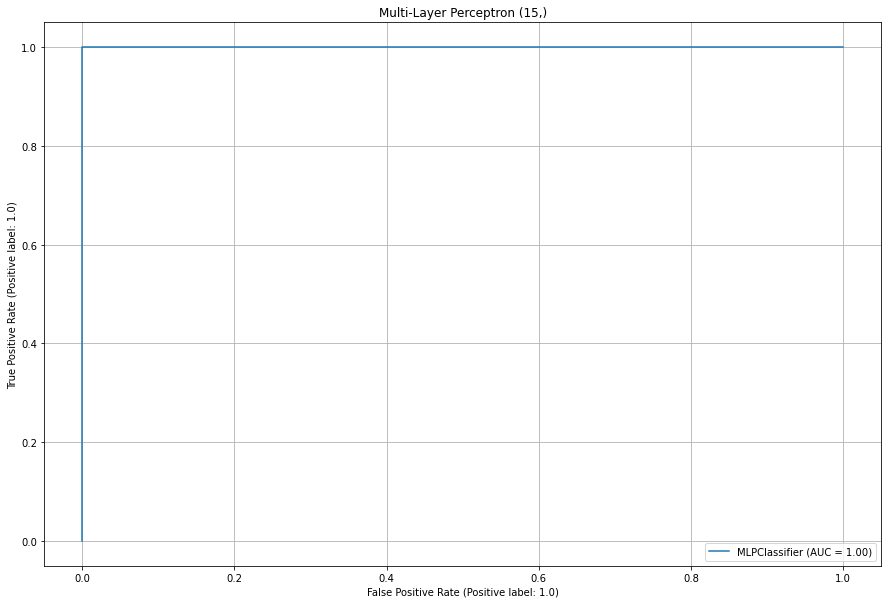

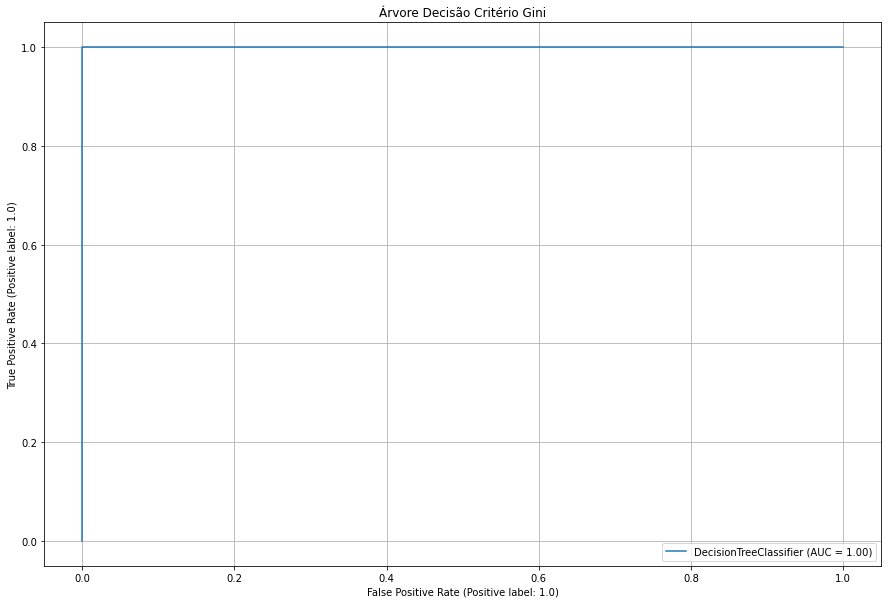

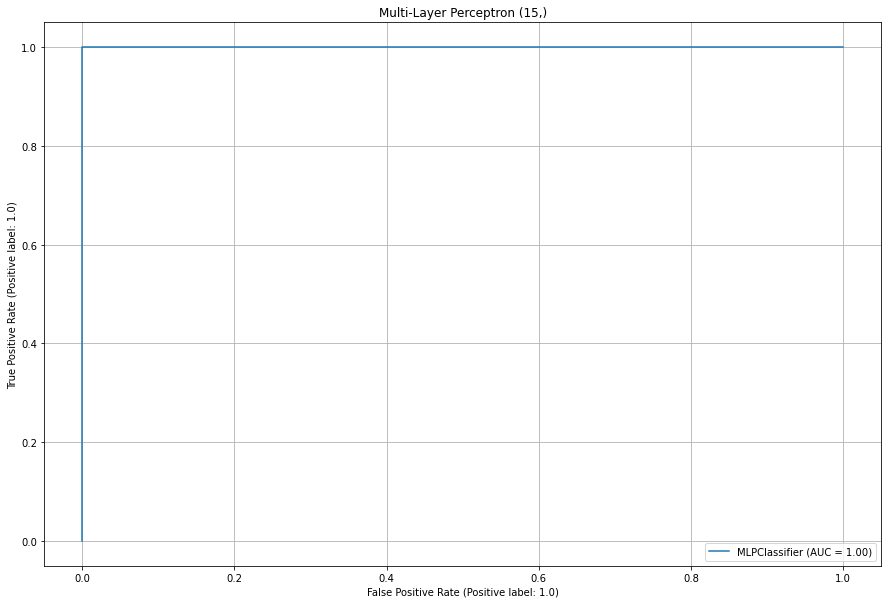

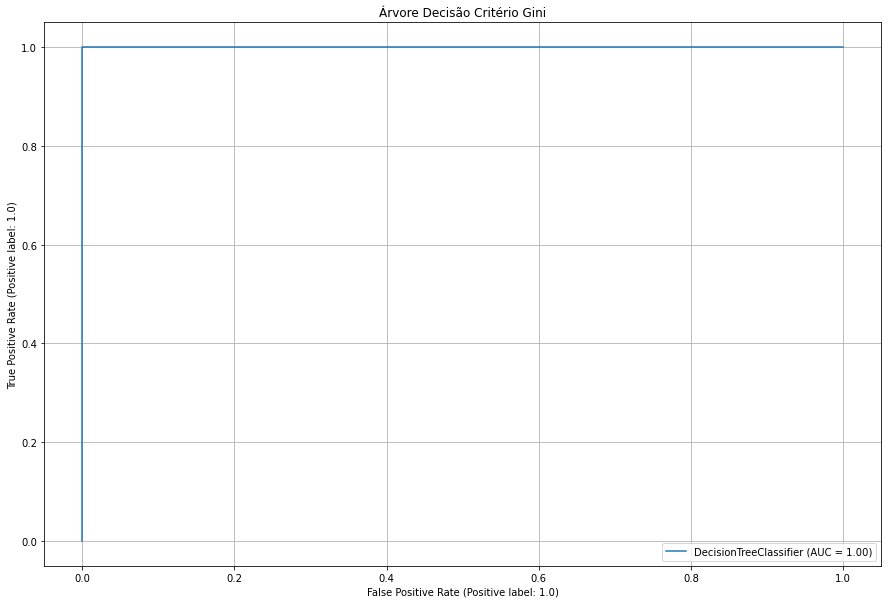

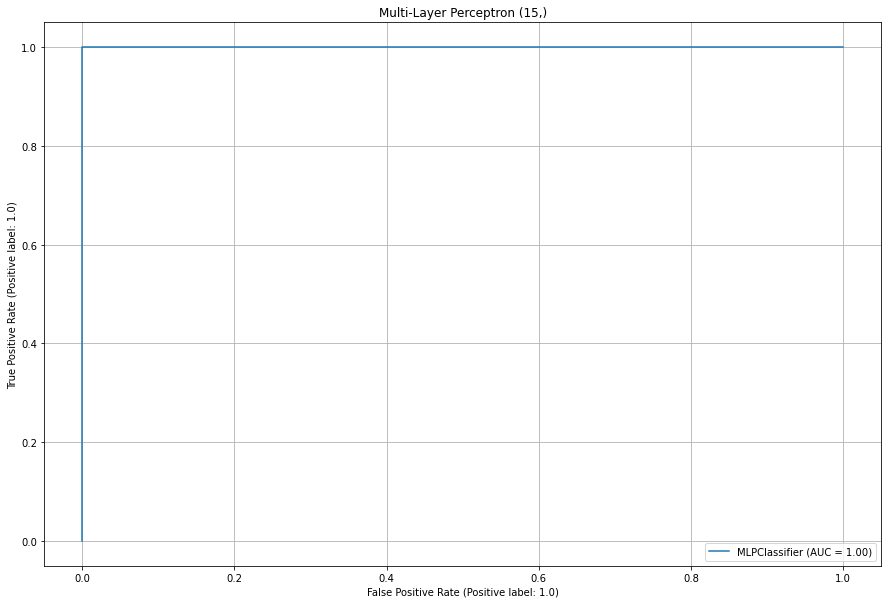

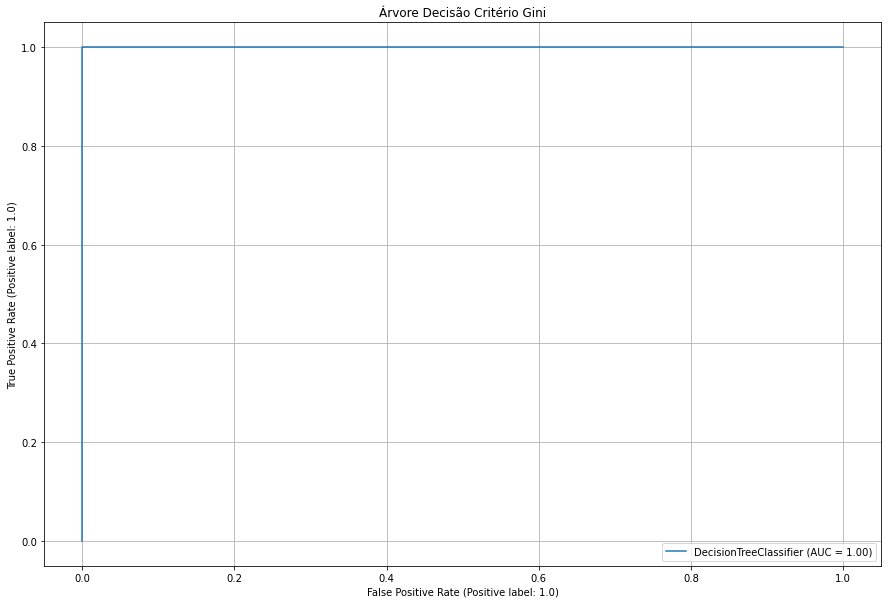

In [16]:
from sklearn.model_selection import KFold

y = df_novo["Survived"]
X = df_novo

classificadores = {
#   "Perceptron" : {"modelo": Perceptron( random_state=int(time.time())), "scores": []},
  "Multi-Layer Perceptron (15,)" : {"modelo": MLPClassifier(hidden_layer_sizes=(15,), max_iter=2000), "scores": []},
  "Árvore Decisão Critério Gini" : {"modelo": DecisionTreeClassifier(criterion='gini'), "scores": []},  
#   "KNN k=5" : {"modelo": KNeighborsClassifier( n_neighbors=5), "scores": []}
}
# prepara validação cruzada
# faz divisão do dataset em fold partes
kf = KFold(n_splits = 10)

for train_index, test_index in kf.split(df_novo):     
    for classificador_name in classificadores:  

        classificadores[classificador_name]["modelo"].fit(X=X_train, y=y_train) # 2) Fit

        # valores preditos pelo classificador
        y_pred = classificadores[classificador_name]["modelo"].predict(X_test)  # 3) Predict
        y_test = np.array(y_test)

        classificadores[classificador_name]["scores"].append(accuracy_score(y_test, y_pred))
        metrics.plot_roc_curve(classificadores[classificador_name]["modelo"], X_test, y_test) 

         # 4) Avaliação com plot_roc_curve
        plt.title(classificador_name)
        plt.grid()
        plt.show() 

In [17]:
# classificadores["Multi-Layer Perceptron (15,)"]["scores"][2] = 0 #Gambiarra pra ver se funciona
# classificadores["Árvore Decisão Critério Gini"]["scores"][2] = 0s

### Questão 04.

Verifique se há diferença estatística significante entre suas acurácias da questão anterior utilizando o teste T (`scipy.stats.ttest_ind`). Considere que há diferença significante se p <= 0.05 (rejeita-se a hipótese nula)

In [20]:
from scipy.stats import ttest_ind 

print(ttest_ind(classificadores["Multi-Layer Perceptron (15,)"]["scores"] , classificadores["Multi-Layer Perceptron (15,)"]["scores"]))
print(ttest_ind(classificadores["Árvore Decisão Critério Gini"]["scores"] , classificadores["Árvore Decisão Critério Gini"]["scores"]))


print("Eu consigo identificar o problema mas eu não sei como arrumar. Todos os resultados dos classificadoressaem identicos e eu não consigo usar o ttest_ind pra isso")


Eu consigo identificar o problema mas eu não sei como arrumar. Todos os resultados dos classificadoressaem identicos e eu não consigo usar o ttest_ind pra isso


Ttest_indResult(statistic=nan, pvalue=nan)

In [19]:
print("It took {:.2f} seconds".format(time.time() - start))

It took 96.87 seconds
